In [1]:
import glob
import librosa
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
import os
import pathlib
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tanvipenumudy","key":"9d7a7b8c87f18fd1e9a2b9bb31134df9"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:10<00:00, 155MB/s]
100% 1.21G/1.21G [00:10<00:00, 122MB/s]


In [5]:
!ls

gtzan-dataset-music-genre-classification.zip  kaggle.json  sample_data


In [6]:
!unzip "gtzan-dataset-music-genre-classification.zip" -d /tmp

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: /tmp/Data/features_30_sec.csv  
  inflating: /tmp/Data/features_3_sec.csv  
  inflating: /tmp/Data/genres_original/blues/blues.00000.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00001.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00002.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00003.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00004.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00005.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00006.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00007.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00008.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00009.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00010.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00011.wav  
  inflating: /tmp/Data/genres_original/blues/blues.00012.wav  
  inflating: /tmp/Data/genres_origina

In [7]:
import os
print(len(os.listdir('/tmp/Data/genres_original')))
print(len(os.listdir('/tmp/Data/genres_original/blues')))
print(len(os.listdir('/tmp/Data/genres_original/classical')))

10
100
100


In [8]:
temp = '/tmp/Data/genres_original/blues/blues.00083.wav'
x, sr = librosa.load(temp)
print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(661794,) 22050


In [9]:
x

array([-0.0244751 , -0.0541687 , -0.08081055, ..., -0.10940552,
       -0.03323364, -0.1116333 ], dtype=float32)

In [18]:
import csv

In [19]:
header = ['filename','chroma_stft','rmse','spectral_centroid','spectral_bandwidth','rolloff','zero_crossing_rate']
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'

In [37]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = ['blues','classical','country','disco','hiphop','metal','pop','reggae','rock']
for g in genres:
    for filename in os.listdir(f'/tmp/Data/genres_original/{g}'):
        songname = f'/tmp/Data/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [38]:
data = pd.read_csv('data.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00071.wav,0.305262,0.120542,2429.260934,2286.625281,5065.027706,0.134687,-89.357906,93.786055,-14.574538,54.391654,-33.508380,19.420994,-19.761601,13.026320,-13.865957,14.607766,-14.969526,10.585571,-18.026934,6.654247,-10.204747,6.527642,-10.846745,3.319423,-6.189024,2.994841,blues
1,blues.00073.wav,0.341865,0.259714,2094.919420,2158.335963,4482.447895,0.100570,-30.094571,103.732289,-19.754240,56.404770,-12.710990,20.188002,-17.340381,16.292435,-18.439600,8.924175,-11.648016,11.213472,-8.842511,9.090302,-3.579252,4.372714,-2.830807,4.725089,0.485058,1.475955,blues
2,blues.00007.wav,0.307921,0.131785,1451.754147,1577.369917,2955.348796,0.061435,-179.395447,136.459244,-26.656359,39.988027,5.289679,10.924427,-20.561889,8.513764,-11.356908,-3.469077,-8.414554,-6.954827,-3.544535,-8.051242,-8.959537,-8.424337,-10.558885,-10.788159,-4.693749,-8.638613,blues
3,blues.00000.wav,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596742,121.557302,-19.158825,42.351029,-6.376457,18.618875,-13.697911,15.344630,-12.285266,10.980491,-8.324323,8.810668,-3.667367,5.751690,-5.162761,0.750947,-1.691937,-0.409954,-2.300208,1.219928,blues
4,blues.00070.wav,0.322734,0.106164,2159.546654,2130.376826,4685.046670,0.098349,-133.015981,105.722690,-22.138973,41.818620,-26.988738,19.122450,-26.566396,19.239805,-15.332086,6.986052,-10.813206,6.791205,-11.727092,4.397390,-6.039441,1.966114,-12.320324,3.253893,-8.809824,-3.379920,blues


In [39]:
data.shape

(900, 28)

In [40]:
data = data.drop(['filename'],axis=1)

In [41]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [42]:
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.305262,0.120542,2429.260934,2286.625281,5065.027706,0.134687,-89.357906,93.786055,-14.574538,54.391654,-33.508380,19.420994,-19.761601,13.026320,-13.865957,14.607766,-14.969526,10.585571,-18.026934,6.654247,-10.204747,6.527642,-10.846745,3.319423,-6.189024,2.994841,blues
1,0.341865,0.259714,2094.919420,2158.335963,4482.447895,0.100570,-30.094571,103.732289,-19.754240,56.404770,-12.710990,20.188002,-17.340381,16.292435,-18.439600,8.924175,-11.648016,11.213472,-8.842511,9.090302,-3.579252,4.372714,-2.830807,4.725089,0.485058,1.475955,blues
2,0.307921,0.131785,1451.754147,1577.369917,2955.348796,0.061435,-179.395447,136.459244,-26.656359,39.988027,5.289679,10.924427,-20.561889,8.513764,-11.356908,-3.469077,-8.414554,-6.954827,-3.544535,-8.051242,-8.959537,-8.424337,-10.558885,-10.788159,-4.693749,-8.638613,blues
3,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596742,121.557302,-19.158825,42.351029,-6.376457,18.618875,-13.697911,15.344630,-12.285266,10.980491,-8.324323,8.810668,-3.667367,5.751690,-5.162761,0.750947,-1.691937,-0.409954,-2.300208,1.219928,blues
4,0.322734,0.106164,2159.546654,2130.376826,4685.046670,0.098349,-133.015981,105.722690,-22.138973,41.818620,-26.988738,19.122450,-26.566396,19.239805,-15.332086,6.986052,-10.813206,6.791205,-11.727092,4.397390,-6.039441,1.966114,-12.320324,3.253893,-8.809824,-3.379920,blues


In [43]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [70]:
from sklearn.model_selection import train_test_split

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [108]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(675, 26) (225, 26) (675,) (225,)


In [109]:
print(np.unique(y_train,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([78, 75, 72, 72, 73, 75, 79, 75, 76]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([22, 25, 28, 28, 27, 25, 21, 25, 24]))


In [110]:
from keras.utils import to_categorical

In [111]:
#One-hot encoding 
print("Before:", y_train.shape)
print("Before:", y_test.shape)
y_train = to_categorical(y_train, 9)
y_test = to_categorical(y_test, 9)
print("After: ", y_train.shape)
print("After: ", y_test.shape)

Before: (675,)
Before: (225,)
After:  (675, 9)
After:  (225, 9)


In [112]:
X_train = X_train.reshape(-1, 1, 26)
X_test  = X_test.reshape(-1, 1, 26)

In [81]:
from tensorflow.keras.layers import Dense,Dropout,Activation,LSTM,GRU,SimpleRNN,Embedding
import time

In [ ]:
from keras.layers import Input
from tensorflow.keras.callbacks import History 
import time

In [97]:
layer = [1,2,3,4]
l_train, l_test, tl, pl = [],[],[],[]
for i in range(len(layer)):
    model=Sequential()
    model.add(SimpleRNN(64,input_shape=(1, 26))) 
    for j in range(layer[i]):
        model.add(Dense(32, activation="tanh"))
    model.add(Dense(9, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    t=time.time()
    model.fit(X_train,y_train,epochs=100)
    tl.append(time.time()-t)
    pl.append(model.count_params())
    print("Time taken:", time.time()-t)
    print("Parameters:", model.count_params())
    l_train.append(model.evaluate(X_train,y_train,verbose = False)[-1])
    l_test.append(model.evaluate(X_test,y_test,verbose = False)[-1])

Epoch 1/100
22/22 [==============================] - 0s 3ms/step - loss: 1.9430 - accuracy: 0.2770
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1.6201 - accuracy: 0.4044
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 1.4914 - accuracy: 0.4800
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 1.4053 - accuracy: 0.5067
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 1.3383 - accuracy: 0.5452
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 1.2853 - accuracy: 0.5600
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 1.2392 - accuracy: 0.5748
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 1.1918 - accuracy: 0.6074
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 1.1599 - accuracy: 0.6000
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 1.1163 - accuracy: 0.6163
Epoch 11/

In [98]:
nodes = [16,32,64,128]
n_train, n_test, tn, pn = [],[],[],[]
for i in nodes:
    model=Sequential()
    model.add(SimpleRNN(64,input_shape=(1, 26))) 
    model.add(Dense(i,activation="tanh"))
    model.add(Dense(9,activation="softmax"))
    model.compile(loss='categorical_crossentropy',metrics=['accuracy']
              ,optimizer='adam')
    t=time.time()
    model.fit(X_train,y_train,epochs=100)
    tn.append(time.time()-t)
    pn.append(model.count_params())
    print("Time taken:", time.time()-t)
    print("Parameters:", model.count_params())
    n_train.append(model.evaluate(X_train,y_train,verbose = False)[-1])
    n_test.append(model.evaluate(X_test,y_test,verbose = False)[-1])

Epoch 1/100
22/22 [==============================] - 0s 3ms/step - loss: 2.1237 - accuracy: 0.2193
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 1.7717 - accuracy: 0.3896
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 1.6426 - accuracy: 0.4000
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 1.5578 - accuracy: 0.4222
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 1.4882 - accuracy: 0.4637
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 1.4291 - accuracy: 0.4785
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 1.3816 - accuracy: 0.5126
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 1.3351 - accuracy: 0.5274
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 1.2925 - accuracy: 0.5511
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 1.2550 - accuracy: 0.5896
Epoch 11/

In [99]:
import matplotlib.pyplot as plt

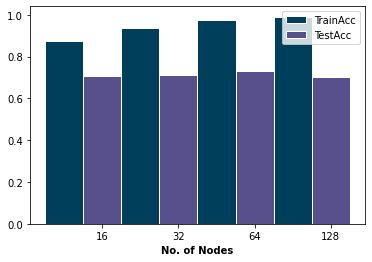

In [100]:
layer=[str(i) for i in layer]
nodes=[str(i) for i in nodes]

barWidth = 0.50

bars1 = n_train
bars2 = n_test

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label='TrainAcc')
plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label='TestAcc')

plt.xlabel('No. of Nodes', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
 
plt.legend()
plt.show()

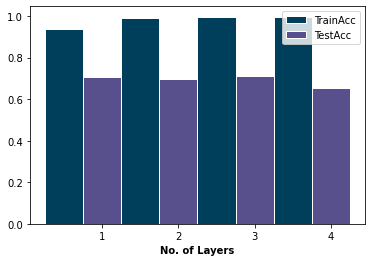

In [101]:
barWidth = 0.50

bars1 = l_train
bars2 = l_test

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label='TrainAcc')
plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label='TestAcc')

plt.xlabel('No. of Layers', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
 
plt.legend()
plt.show()

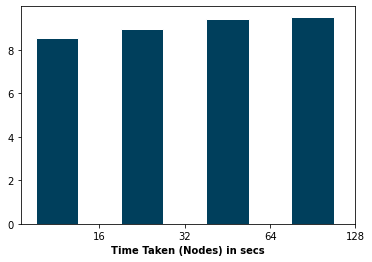

In [102]:
barWidth = 0.50
bars1 = tn
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Time Taken (Nodes) in secs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
plt.show()

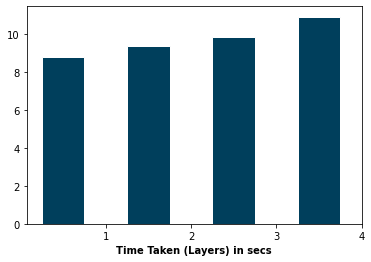

In [103]:
barWidth = 0.50
bars1 = tl
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Time Taken (Layers) in secs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
plt.show()

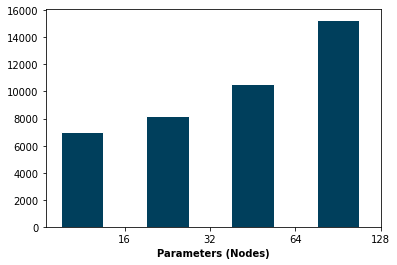

In [104]:
barWidth = 0.50
bars1 = pn
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Parameters (Nodes)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
plt.show()

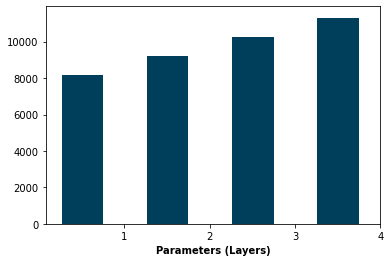

In [105]:
barWidth = 0.50
bars1 = pl
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Parameters (Layers)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
plt.show()

In [114]:
y_train = y_train.reshape(-1, 1, 9)
y_test  = y_test.reshape(-1, 1, 9)

In [115]:
layer = [1,2,3,4]
l_train, l_test, tl, pl = [],[],[],[]
for i in range(len(layer)):
    model=Sequential()
    model.add(LSTM(32, return_sequences=True,
               input_shape=(2, 26)))
    for j in range(layer[i]):
        model.add(LSTM(32, return_sequences=True))
    model.add(Dense(9, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    t=time.time()
    model.fit(X_train,y_train,epochs=100)
    tl.append(time.time()-t)
    pl.append(model.count_params())
    print("Time taken:", time.time()-t)
    print("Parameters:", model.count_params())
    l_train.append(model.evaluate(X_train,y_train,verbose = False)[-1])
    l_test.append(model.evaluate(X_test,y_test,verbose = False)[-1])

Epoch 1/100
22/22 [==============================] - 0s 5ms/step - loss: 2.1782 - accuracy: 0.3126
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 2.1315 - accuracy: 0.3911
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 2.0508 - accuracy: 0.3615
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 1.9309 - accuracy: 0.3541
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 1.8025 - accuracy: 0.3511
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 1.6984 - accuracy: 0.3852
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 1.6221 - accuracy: 0.4059
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 1.5609 - accuracy: 0.4193
Epoch 9/100
22/22 [==============================] - 0s 6ms/step - loss: 1.5091 - accuracy: 0.4326
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 1.4623 - accuracy: 0.4548
Epoch 11/

In [116]:
nodes = [16,32,64,128]
n_train, n_test, tn, pn = [],[],[],[]
for i in nodes:
    model=Sequential()
    model.add(LSTM(32, return_sequences=True,
               input_shape=(2, 26))) 
    model.add(LSTM(i, return_sequences=True))
    model.add(Dense(9,activation="softmax"))
    model.compile(loss='categorical_crossentropy',metrics=['accuracy']
              ,optimizer='adam')
    t=time.time()
    model.fit(X_train,y_train,epochs=100)
    tn.append(time.time()-t)
    pn.append(model.count_params())
    print("Time taken:", time.time()-t)
    print("Parameters:", model.count_params())
    n_train.append(model.evaluate(X_train,y_train,verbose = False)[-1])
    n_test.append(model.evaluate(X_test,y_test,verbose = False)[-1])

Epoch 1/100
22/22 [==============================] - 0s 6ms/step - loss: 2.1838 - accuracy: 0.2059
Epoch 2/100
22/22 [==============================] - 0s 5ms/step - loss: 2.1466 - accuracy: 0.3674
Epoch 3/100
22/22 [==============================] - 0s 5ms/step - loss: 2.0974 - accuracy: 0.4030
Epoch 4/100
22/22 [==============================] - 0s 5ms/step - loss: 2.0288 - accuracy: 0.3674
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 1.9429 - accuracy: 0.3570
Epoch 6/100
22/22 [==============================] - 0s 5ms/step - loss: 1.8549 - accuracy: 0.3585
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 1.7831 - accuracy: 0.3570
Epoch 8/100
22/22 [==============================] - 0s 5ms/step - loss: 1.7192 - accuracy: 0.3644
Epoch 9/100
22/22 [==============================] - 0s 5ms/step - loss: 1.6676 - accuracy: 0.3763
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 1.6203 - accuracy: 0.3911
Epoch 11/

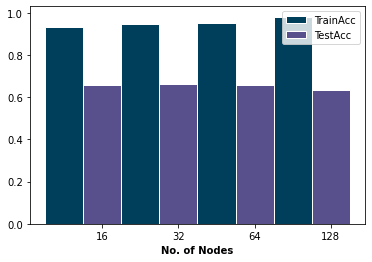

In [117]:
layer=[str(i) for i in layer]
nodes=[str(i) for i in nodes]

barWidth = 0.50

bars1 = n_train
bars2 = n_test

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label='TrainAcc')
plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label='TestAcc')

plt.xlabel('No. of Nodes', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
 
plt.legend()
plt.show()

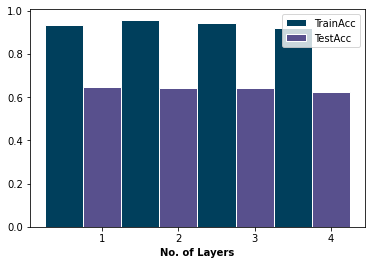

In [118]:
barWidth = 0.50

bars1 = l_train
bars2 = l_test

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label='TrainAcc')
plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label='TestAcc')

plt.xlabel('No. of Layers', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
 
plt.legend()
plt.show()

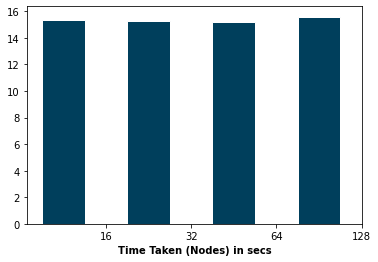

In [119]:
barWidth = 0.50
bars1 = tn
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Time Taken (Nodes) in secs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
plt.show()

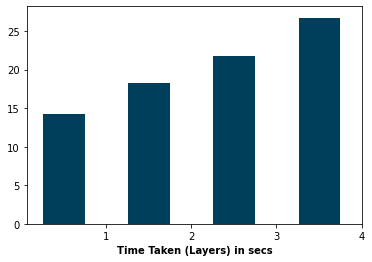

In [120]:
barWidth = 0.50
bars1 = tl
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Time Taken (Layers) in secs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
plt.show()

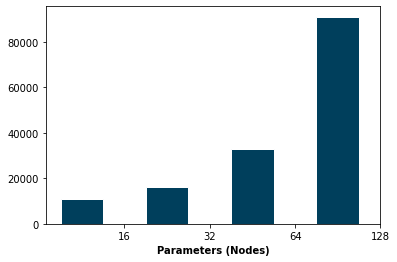

In [121]:
barWidth = 0.50
bars1 = pn
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Parameters (Nodes)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
plt.show()

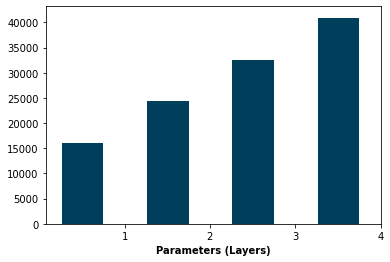

In [122]:
barWidth = 0.50
bars1 = pl
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Parameters (Layers)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
plt.show()

In [123]:
layer = [1,2,3,4]
l_train, l_test, tl, pl = [],[],[],[]
for i in range(len(layer)):
    model=Sequential()
    model.add(GRU(32, return_sequences=True,
               input_shape=(1, 26)))
    for j in range(layer[i]):
        model.add(GRU(32, return_sequences=True))
    model.add(Dense(9, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    t=time.time()
    model.fit(X_train,y_train,epochs=100)
    tl.append(time.time()-t)
    pl.append(model.count_params())
    print("Time taken:", time.time()-t)
    print("Parameters:", model.count_params())
    l_train.append(model.evaluate(X_train,y_train,verbose = False)[-1])
    l_test.append(model.evaluate(X_test,y_test,verbose = False)[-1])
    model = Sequential()

Epoch 1/100
22/22 [==============================] - 0s 5ms/step - loss: 2.1500 - accuracy: 0.2193
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 2.0224 - accuracy: 0.3570
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 1.8932 - accuracy: 0.3733
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 1.7696 - accuracy: 0.3689
Epoch 5/100
22/22 [==============================] - 0s 5ms/step - loss: 1.6596 - accuracy: 0.3896
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 1.5711 - accuracy: 0.4119
Epoch 7/100
22/22 [==============================] - 0s 4ms/step - loss: 1.4943 - accuracy: 0.4341
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 1.4281 - accuracy: 0.4667
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 1.3681 - accuracy: 0.5022
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 1.3140 - accuracy: 0.5230
Epoch 11/

In [124]:
nodes = [16,32,64,128]
n_train, n_test, tn, pn = [],[],[],[]
for i in nodes:
    model=Sequential()
    model.add(GRU(32, return_sequences=True,
               input_shape=(1, 26)))
    model.add(GRU(i, return_sequences=True))
    model.add(Dense(9,activation="softmax"))
    model.compile(loss='categorical_crossentropy',metrics=['accuracy']
              ,optimizer='adam')
    t=time.time()
    model.fit(X_train,y_train,epochs=100)
    tn.append(time.time()-t)
    pn.append(model.count_params())
    print("Time taken:", time.time()-t)
    print("Parameters:", model.count_params())
    n_train.append(model.evaluate(X_train,y_train,verbose = False)[-1])
    n_test.append(model.evaluate(X_test,y_test,verbose = False)[-1])

Epoch 1/100
22/22 [==============================] - 0s 5ms/step - loss: 2.1426 - accuracy: 0.1615
Epoch 2/100
22/22 [==============================] - 0s 4ms/step - loss: 2.0160 - accuracy: 0.3081
Epoch 3/100
22/22 [==============================] - 0s 4ms/step - loss: 1.9056 - accuracy: 0.3600
Epoch 4/100
22/22 [==============================] - 0s 4ms/step - loss: 1.8115 - accuracy: 0.3630
Epoch 5/100
22/22 [==============================] - 0s 4ms/step - loss: 1.7265 - accuracy: 0.3778
Epoch 6/100
22/22 [==============================] - 0s 4ms/step - loss: 1.6559 - accuracy: 0.3956
Epoch 7/100
22/22 [==============================] - 0s 5ms/step - loss: 1.5941 - accuracy: 0.4281
Epoch 8/100
22/22 [==============================] - 0s 4ms/step - loss: 1.5393 - accuracy: 0.4459
Epoch 9/100
22/22 [==============================] - 0s 4ms/step - loss: 1.4890 - accuracy: 0.4607
Epoch 10/100
22/22 [==============================] - 0s 5ms/step - loss: 1.4414 - accuracy: 0.4770
Epoch 11/

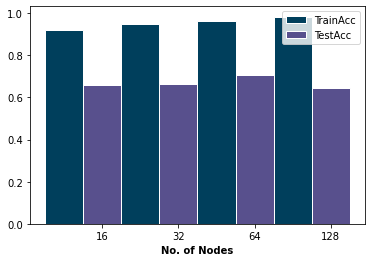

In [125]:
layer=[str(i) for i in layer]
nodes=[str(i) for i in nodes]

barWidth = 0.50

bars1 = n_train
bars2 = n_test

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label='TrainAcc')
plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label='TestAcc')

plt.xlabel('No. of Nodes', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
 
plt.legend()
plt.show()

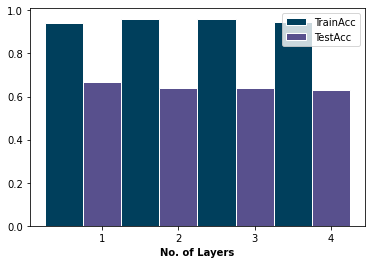

In [126]:
barWidth = 0.50

bars1 = l_train
bars2 = l_test

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white', label='TrainAcc')
plt.bar(r2, bars2, color='#58508d', width=barWidth, edgecolor='white', label='TestAcc')

plt.xlabel('No. of Layers', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
 
plt.legend()
plt.show()

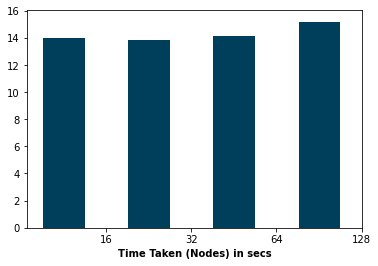

In [127]:
barWidth = 0.50
bars1 = tn
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Time Taken (Nodes) in secs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
plt.show()

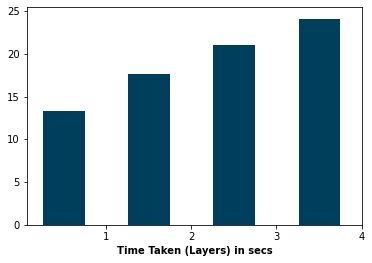

In [128]:
barWidth = 0.50
bars1 = tl
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Time Taken (Layers) in secs', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
plt.show()

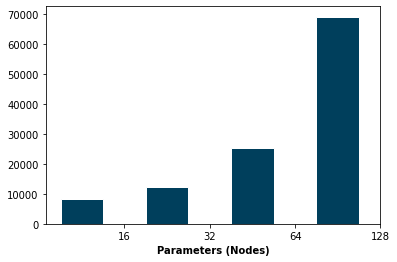

In [129]:
barWidth = 0.50
bars1 = pn
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Parameters (Nodes)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in nodes])
plt.show()

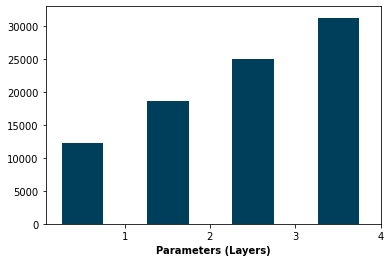

In [130]:
barWidth = 0.50
bars1 = pl
r1 = np.arange(len(bars1))
plt.bar(r1, bars1, color='#003f5c', width=barWidth, edgecolor='white')
plt.xlabel('Parameters (Layers)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [str(i) for i in layer])
plt.show()